# Validating fine-tuned Generator via fine-tuned Classifier

In [1]:
# setup 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pprint
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Any
from datasets import Dataset
import re
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab',quiet=True)


# load data
generated_speeches_df = pd.read_csv("../data/gpt_speeches/gpt_speeches.csv", sep = ";")

# rename label CDU/CSU correctly for mapping later
generated_speeches_df["party"] = generated_speeches_df["party"].replace({
    "Union": "CDU/CSU"
})

generated_speeches_df = generated_speeches_df.dropna(subset=["speech_text"])
generated_speeches_df = generated_speeches_df.rename(columns={"party": "label"})



In [2]:
# delete all party mentions
def extract_party_mentions(speech_text, party):
    
    if not isinstance(speech_text, str):
        return print("nope")

    # make sentences
    sentences = sent_tokenize(speech_text, language='german')
    
    # party to lower
    party_lower = party.lower()
    
    # filter sent where own party is mentioned
    matched = [s for s in sentences if party_lower in s.lower()]
    
    return matched


results = []

for idx, speech in generated_speeches_df.iterrows():
    party = speech['label']
    matches = extract_party_mentions(speech['speech_text'], party)
    if matches:  
        for match in matches:
            results.append({'party': party, 'match': match})

df_matches = pd.DataFrame(results)

def extract_and_remove_party_mentions(speech_text, party):
    if not isinstance(speech_text, str):
        return [], speech_text

    sentences = sent_tokenize(speech_text, language='german')
    party_lower = party.lower()

    matched = [s for s in sentences if party_lower in s.lower()]
    cleaned = [s for s in sentences if party_lower not in s.lower()]

    cleaned_text = ' '.join(cleaned)
    return matched, cleaned_text


results = []
clean_texts = []

for idx, row in generated_speeches_df.iterrows():
    matches, cleaned_text = extract_and_remove_party_mentions(row['speech_text'], row['label'])
    results.append({'party': row['label'], 'matches': matches})
    clean_texts.append(cleaned_text)

df_matches = pd.DataFrame(results)
generated_speeches_df['speech_text'] = clean_texts


In [3]:
# subset important columns and convert to huggingface Dataset
generated_speeches_df = generated_speeches_df[["speech_text", "label"]]
generated_speeches_df = Dataset.from_pandas(generated_speeches_df)

In [4]:
# load best classifier model
# Load model and tokenizer from local folder
model = AutoModelForSequenceClassification.from_pretrained("../data/Classifier_gbert_fulltext_weighted")
tokenizer = AutoTokenizer.from_pretrained("../data/Classifier_gbert_fulltext_weighted")


/Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 6): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: /Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in: /Users/ellaalle/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-08-06 19:07:48.723074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To en

In [5]:
# define parameters
WINDOW_LENGTH = 512
STRIDE = 256
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']

In [6]:
# model und tokenizer müssen schon geladen sein
model.eval()

def tokenize_sliding_windows(example: Dict[str, Any]) -> Dict[str, Any]:
    #print(type(example["speech_text"]), example["speech_text"])
    encoding = tokenizer(
        example["speech_text"],
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False,
        return_tensors="pt"
    )
    return encoding

def predict_proba_for_dataset(dataset: Dataset, label_names) -> List[Dict[str, Any]]:
    results = []

    for example in tqdm(dataset):
        tokenized = tokenize_sliding_windows(example)
        input_ids = tokenized["input_ids"].to(model.device)
        attention_mask = tokenized["attention_mask"].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

        avg_probs = probs.mean(axis=0)
        results.append({
            "probs": avg_probs.tolist(),
            "label": example["label"]  # falls du wahren Wert mitgeben willst
        })

    for item in results:
      probs = item["probs"]
      pred_idx = int(np.argmax(probs))
      item["prediction_label"] = label_names[pred_idx]
    return results


In [7]:
# define function to display eval metrics
def get_metrics(true_labels, preds, model_name):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary



In [8]:
results = predict_proba_for_dataset(generated_speeches_df, sorted(label_names))

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:43<00:00,  2.08s/it]


Model: GPT-4mini
  Accuracy: 0.5714285714285714
  Balanced Accuracy: 0.5
  Precision: 0.6137566137566138
  Recall: 0.5
  F1-score: 0.4523476523476524
  Classification Report:
              precision    recall  f1-score   support

         AFD       0.00      0.00      0.00         1
     CDU/CSU       1.00      0.25      0.40         4
         FDP       0.67      0.50      0.57         4
       GRÜNE       0.57      1.00      0.73         4
       LINKE       1.00      0.25      0.40         4
         SPD       0.44      1.00      0.62         4

    accuracy                           0.57        21
   macro avg       0.61      0.50      0.45        21
weighted avg       0.70      0.57      0.52        21



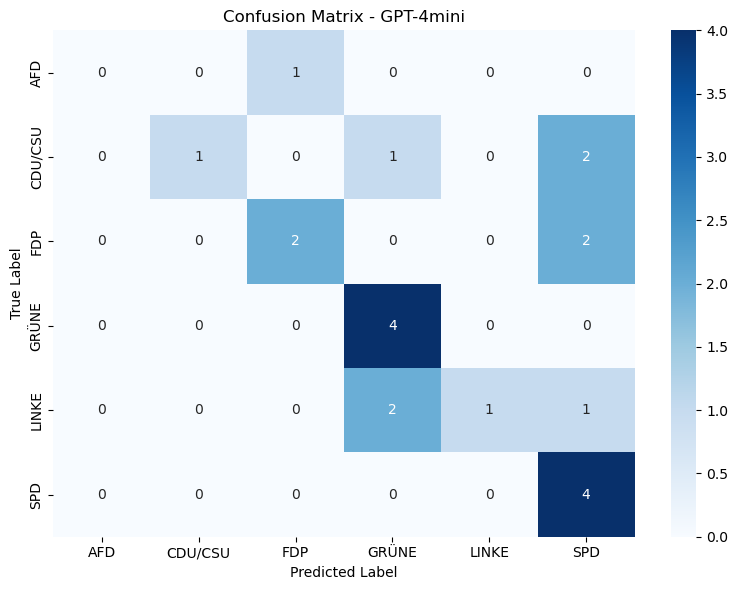

In [9]:
true_labels = [item["label"] for item in results]
predicted_labels = [item["prediction_label"] for item in results]

results_metrics = get_metrics(true_labels, predicted_labels, "GPT-4mini")



In [10]:
# final results
final_performance_results_df = pd.DataFrame(results_metrics)
final_performance_results_df

,GPT-4mini
acc,0.571429
bal_acc,0.500000
precision,0.613757
recall,0.500000
f1,0.452348


In [11]:
# Visualising the results
def visualising_results(metrics_summary, results):
    """Producing comprehensive visualisation that works with any number of models"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    model_names = results
    num_models = len(model_names)

    accuracies = [metrics_summary[name]['acc'] for name in model_names]
    balanced_accuracies = [metrics_summary[name]['bal_acc'] for name in model_names]
    precisions = [metrics_summary[name]['precision'] for name in model_names]
    recalls = [metrics_summary[name]['recall'] for name in model_names]
    f1_scores = [metrics_summary[name]['f1'] for name in model_names]

    # Subplot 1: Accuracy
    axes[0, 0].bar(np.arange(num_models) - 0.2, accuracies, width=0.4, label='Accuracy', color='skyblue')
    axes[0, 0].bar(np.arange(num_models) + 0.2, balanced_accuracies, width=0.4, label='Balanced Accuracy', color='lightgreen')
    axes[0, 0].set_title('Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xticks(np.arange(num_models))
    axes[0, 0].set_xticklabels(model_names, rotation=45)
    axes[0, 0].legend()

    # Subplot 2: Precision and Recall
    width = 0.35
    x = np.arange(num_models)
    axes[0, 1].bar(x - width/2, precisions, width, label='Precision', alpha=0.7, color='orange')
    axes[0, 1].bar(x + width/2, recalls, width, label='Recall', alpha=0.7, color='red')
    axes[0, 1].set_title('Precision and Recall')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(model_names, rotation=45)
    axes[0, 1].legend()

    # Subplot 3: F1
    axes[1, 0].bar(model_names, f1_scores, alpha=0.7, color='purple')
    axes[1, 0].set_title('F1 Score Comparison')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Subplot 4: Overall Performance Comparison
    metrics = ['Exact Acc', 'Partial Acc', 'Precision', 'Recall', 'F1']
    for idx, name in enumerate(model_names):
        model_scores = [
            accuracies[idx],
            balanced_accuracies[idx],
            precisions[idx],
            recalls[idx],
            f1_scores[idx],
        ]
        marker = ['o', 's', '^', 'D', 'x'][idx % 5]  # Use different markers
        axes[1, 1].plot(metrics, model_scores, marker + '-', label=name, linewidth=2, markersize=8)

    axes[1, 1].set_title('Overall Performance Comparison')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


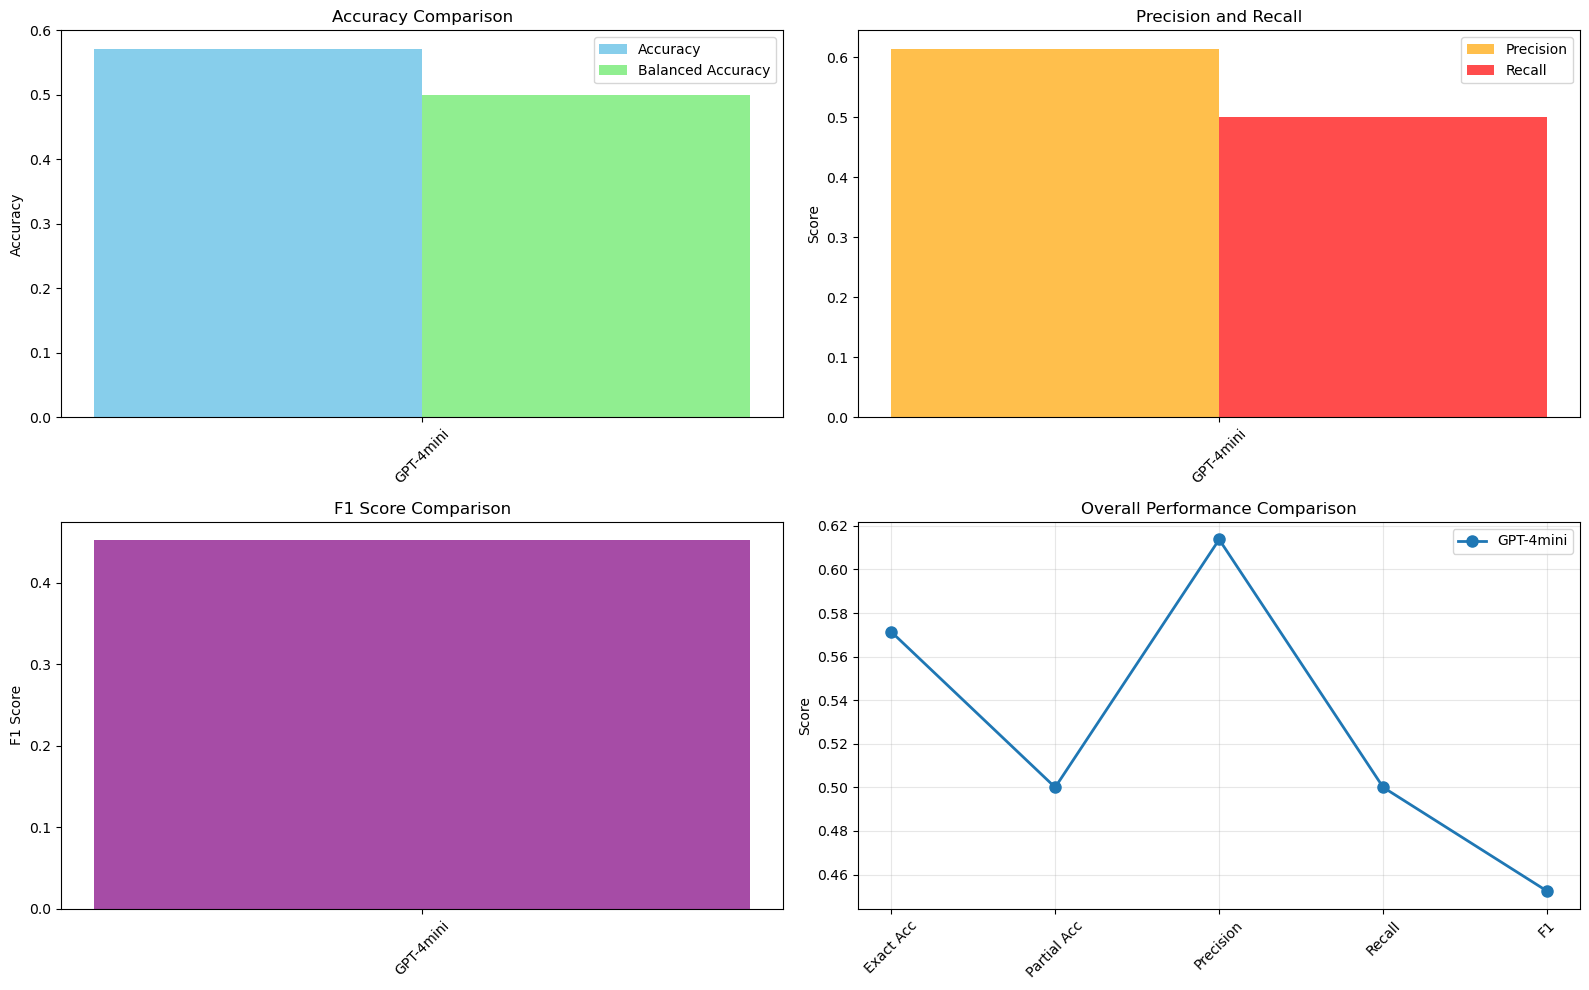

In [12]:
visualising_results(results_metrics, results = ["GPT-4mini"])